In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# DATASET

In [55]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
drug_reviews_druglib_com = fetch_ucirepo(id=461) 
df = drug_reviews_druglib_com.data.features[['rating', 'effectiveness', 'sideEffects', 'benefitsReview', 'sideEffectsReview', 'commentsReview']]
df = df.dropna().copy()
  
label_encoders = {}
categorical_columns = ['effectiveness', 'sideEffects', 'rating']
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])
    
X = df.drop(columns=categorical_columns)
y = df[categorical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

y_train_rating, y_train_effectiveness, y_train_side_effects = (
    y_train['rating'], y_train['effectiveness'], y_train['sideEffects']
)
y_test_rating, y_test_effectiveness, y_test_side_effects = (
    y_test['rating'], y_test['effectiveness'], y_test['sideEffects']
)

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

### Device

In [4]:
# check if runs on Apple Silicon efficiently

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    raise Exception("MPS not available")

else:
    device = torch.device("mps")
    print("MPS enabled")

MPS enabled


In [5]:
### Hyperparameters

In [6]:
max_len = 128
batch_size = 32
epochs = 10
lr = 1e-3


In [7]:
# from transformers import PreTrainedTokenizer
# 
# 
# class DruglibDataset(Dataset):
#     def __init__(self, reviews: pd.Series, targets: pd.Series, tokenizer: PreTrainedTokenizer, max_len: int):
#         self.reviews = reviews
#         self.targets = targets
#         self.tokenizer = tokenizer
#         self.max_len = max_len
# 
#     def __len__(self) -> int:
#         return len(self.reviews)
# 
#     def __getitem__(self, idx: int) -> dict:
#         review_text = str(self.reviews.iloc[idx])
#         target = self.targets.iloc[idx]
# 
#         encoding = self.tokenizer.encode_plus(
#             review_text,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             return_token_type_ids=False,
#             padding='max_length',
#             return_attention_mask=True,
#             return_tensors='pt',
#             truncation=True
#         )
# 
#         return {
#             'review_text': review_text,
#             'input_ids': encoding['input_ids'].flatten(),
#             'attention_mask': encoding['attention_mask'].flatten(),
#             'targets': torch.tensor(target, dtype=torch.long)
#         }

### Data loaders and datasets

In [8]:
# def gen_data_loader(reviews, targets, tokenizer, max_len, batch_size):
#     ds = DruglibDataset(reviews, targets, tokenizer, max_len)
#     return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [22]:
from transformers import BertTokenizer, GPT2Tokenizer
from time_series.dataset import gen_data_loader

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

data_loader_side_effects_train = gen_data_loader(X_train, y_train_side_effects, bert_tokenizer, max_len, batch_size)
data_loader_side_effects_test = gen_data_loader(X_test, y_test_side_effects, bert_tokenizer, max_len, batch_size)

data_loader_effectiveness_train = gen_data_loader(X_train, y_train_effectiveness, bert_tokenizer, max_len, batch_size)
data_loader_effectiveness_test = gen_data_loader(X_test, y_test_effectiveness, bert_tokenizer, max_len, batch_size)

data_loader_rating_train = gen_data_loader(X_train, y_train_rating, bert_tokenizer, max_len, batch_size)
data_loader_rating_test = gen_data_loader(X_test, y_test_rating, bert_tokenizer, max_len, batch_size)


In [23]:
vocab_size = len(bert_tokenizer)
embedding_dim = 128
hidden_size = 256
output_sizes = {
    'rating': len(df['rating'].unique()),
    'effectiveness': len(df['effectiveness'].unique()),
    'sideEffects': len(df['sideEffects'].unique())
}

# RNN

In [36]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.2):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# GRU

In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.2):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# GRU-LSTM

In [62]:
class GRULSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_gru_layers=1, num_lstm_layers=1, dropout=0.2):
        super(GRULSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, num_layers=num_gru_layers, dropout=dropout)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=num_lstm_layers, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        lstm_out, _ = self.lstm(gru_out)
        lstm_out = lstm_out[:, -1, :]

        out = self.fc1(lstm_out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# GPT2

In [28]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel


class GPT2Classifier(nn.Module):
    def __init__(self, n_labels):
        super(GPT2Model, self).__init__()
        config = GPT2Config.from_pretrained("gpt2")
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", config=config)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(config.hidden_size, n_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.gpt2(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]
        pooled_output = hidden_states[:, -1, :]
        pooled_output = self.dropout(pooled_output)
        return self.linear(pooled_output)

# BERT

In [29]:
from transformers import BertModel, BertConfig


class BERTModel(nn.Module):
    def __init__(self, n_labels):
        super(BERTModel, self).__init__()
        config = BertConfig.from_pretrained("bert-base-cased")
        self.bert = BertModel.from_pretrained("bert-base-cased", config=config)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(config.hidden_size, n_labels)

    def forward(self, input_ids, attention_mask=None):
        hidden_states = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled_output = hidden_states[:, -1]
        dropout_output = self.dropout(pooled_output)
        return self.linear(dropout_output)

# Training

In [31]:

import torch.nn as nn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [58]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    model.to(device)

    targets_all = []
    predictions_all = []
    test_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            targets = batch['targets'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            targets_all.extend(targets.cpu().numpy())
            predictions_all.extend(predictions.cpu().numpy())

    test_loss /= len(dataloader)
    accuracy = accuracy_score(targets_all, predictions_all)
    balanced_accuracy = balanced_accuracy_score(targets_all, predictions_all)
    f1 = f1_score(targets_all, predictions_all, average='weighted')
    precision = precision_score(targets_all, predictions_all, average='weighted')
    recall = recall_score(targets_all, predictions_all, average='weighted')
    
    try:
        roc_auc = roc_auc_score(targets_all, predictions_all, multi_class='ovr')
    except ValueError:
        roc_auc = None
        
    conf_matrix = confusion_matrix(targets_all, predictions_all)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'ROC AUC: {roc_auc}')
    print(f'Confusion Matrix: \n{conf_matrix}')

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return accuracy, balanced_accuracy, f1, precision, recall, roc_auc, conf_matrix

In [63]:
epochs = 10

import torch

def train_model(model, optimizer, train_loader, val_loader, criterion, epochs=10, device='cuda'):
    model.to(device)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    def train_one_epoch():
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        return epoch_loss, epoch_accuracy

    def validate_one_epoch():
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                targets = batch['targets'].to(device)

                outputs = model(input_ids)
                loss = criterion(outputs, targets)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_loss = running_loss / len(val_loader)
        epoch_accuracy = correct / total
        return epoch_loss, epoch_accuracy

    for epoch in range(epochs):
        train_loss, train_accuracy = train_one_epoch()
        val_loss, val_accuracy = validate_one_epoch()

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return history['train_loss'], history['val_loss'], history['train_accuracy'], history['val_accuracy']


In [64]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses, figsize=(14, 7)):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Training RNN model for rating
Epoch 1/10, Training Loss: 2.1553, Training Accuracy: 0.2059, Test Loss: 2.2007, Test Accuracy: 0.1606
Epoch 2/10, Training Loss: 2.1374, Training Accuracy: 0.2124, Test Loss: 2.1852, Test Accuracy: 0.1606
Epoch 3/10, Training Loss: 2.1333, Training Accuracy: 0.2040, Test Loss: 2.1892, Test Accuracy: 0.1606
Epoch 4/10, Training Loss: 2.1291, Training Accuracy: 0.2127, Test Loss: 2.1804, Test Accuracy: 0.1606
Epoch 5/10, Training Loss: 2.1263, Training Accuracy: 0.2152, Test Loss: 2.1755, Test Accuracy: 0.1606
Epoch 6/10, Training Loss: 2.1223, Training Accuracy: 0.2102, Test Loss: 2.1663, Test Accuracy: 0.1606
Epoch 7/10, Training Loss: 2.1284, Training Accuracy: 0.2136, Test Loss: 2.1705, Test Accuracy: 0.1606
Epoch 8/10, Training Loss: 2.1357, Training Accuracy: 0.2052, Test Loss: 2.1896, Test Accuracy: 0.1606
Epoch 9/10, Training Loss: 2.1304, Training Accuracy: 0.2052, Test Loss: 2.1777, Test Accuracy: 0.1606
Epoch 10/10, Training Loss: 2.1269, Traini

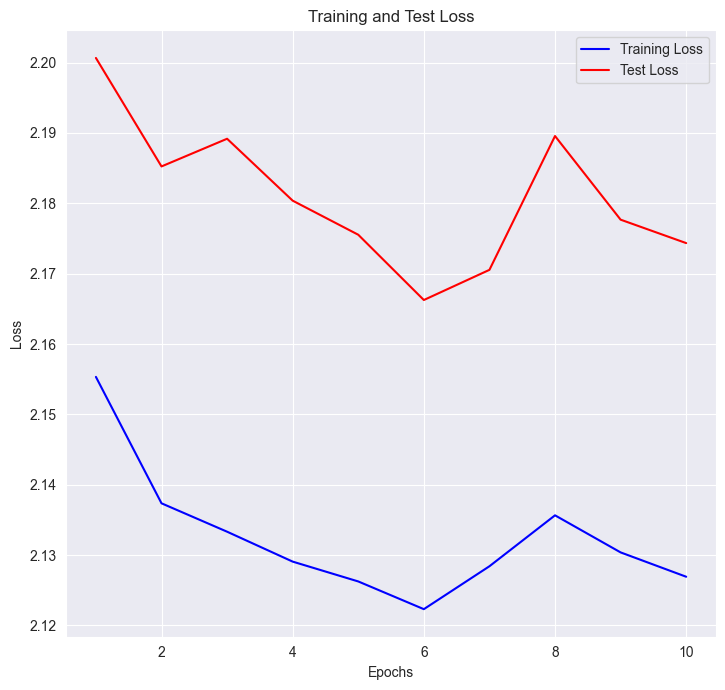


Evaluating Improved RNN model for rating
targets_all [0, 6, 8, 9, 2, 9, 0, 4, 3, 6, 3, 9, 4, 6, 5, 7, 7, 9, 9, 6, 3, 8, 9, 7, 4, 8, 2, 8, 4, 0, 8, 9, 8, 4, 8, 8, 0, 7, 4, 0, 8, 9, 9, 6, 8, 9, 7, 2, 0, 2, 9, 6, 0, 0, 5, 9, 9, 8, 5, 9, 9, 9, 8, 2, 7, 7, 5, 6, 5, 6, 5, 8, 9, 6, 6, 9, 8, 7, 7, 8, 5, 5, 8, 9, 8, 6, 6, 8, 7, 9, 6, 8, 9, 0, 7, 1, 0, 5, 9, 8, 3, 8, 0, 8, 7, 7, 8, 7, 7, 6, 9, 7, 6, 9, 9, 7, 9, 7, 9, 0, 8, 7, 7, 7, 0, 6, 9, 2, 0, 6, 9, 9, 3, 8, 9, 6, 5, 9, 7, 7, 3, 7, 3, 7, 9, 8, 7, 0, 3, 8, 5, 9, 9, 7, 0, 9, 9, 3, 9, 8, 9, 7, 9, 8, 0, 6, 0, 5, 4, 2, 7, 4, 5, 7, 8, 7, 8, 0, 0, 4, 6, 3, 0, 9, 9, 4, 7, 1, 7, 8, 2, 0, 8, 7, 8, 0, 9, 7, 7, 5, 2, 9, 0, 8, 9, 0, 0, 9, 6, 6, 8, 1, 0, 7, 6, 7, 8, 9, 9, 7, 8, 7, 9, 3, 9, 2, 5, 9, 1, 8, 6, 3, 4, 6, 9, 9, 7, 5, 6, 9, 6, 7, 2, 2, 8, 4, 7, 9, 1, 9, 5, 6, 9, 9, 9, 5, 2, 9, 1, 9, 1, 8, 9, 4, 9, 3, 0, 4, 6, 3, 8, 3, 0, 7, 0, 9, 7, 9, 2, 0, 2, 9, 0, 0, 0, 5, 9, 6, 8, 7, 9, 9, 9, 0, 9, 7, 0, 9, 7, 5, 9, 8, 0, 0, 9, 7, 9, 8, 0, 6, 5, 1, 9, 0, 3, 

/Users/rmajor/Library/Caches/pypoetry/virtualenvs/neuralnetworks-S6rdj6Tk-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


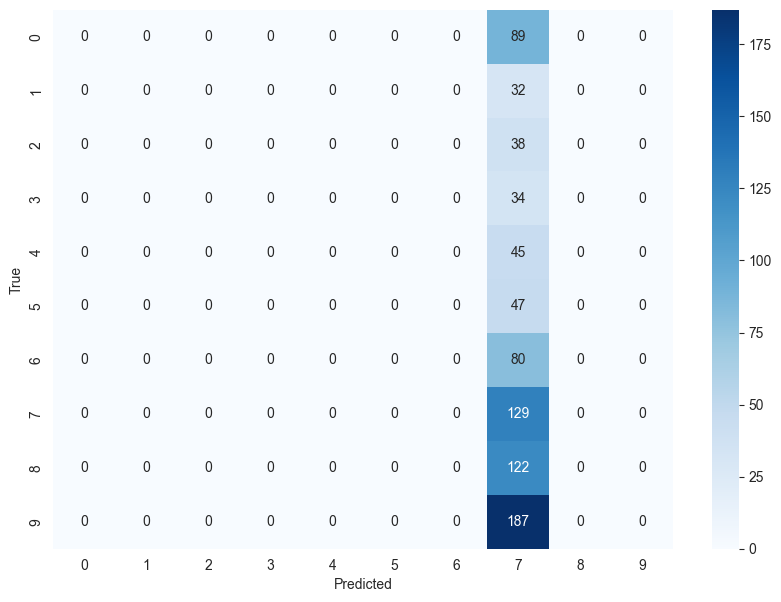


Training RNN model for effectiveness
Epoch 1/10, Training Loss: 1.4133, Training Accuracy: 0.3880, Test Loss: 1.4376, Test Accuracy: 0.2889
Epoch 2/10, Training Loss: 1.3992, Training Accuracy: 0.3971, Test Loss: 1.4146, Test Accuracy: 0.4147
Epoch 3/10, Training Loss: 1.3914, Training Accuracy: 0.4083, Test Loss: 1.4112, Test Accuracy: 0.4147
Epoch 4/10, Training Loss: 1.3903, Training Accuracy: 0.4092, Test Loss: 1.4062, Test Accuracy: 0.4147
Epoch 5/10, Training Loss: 1.3876, Training Accuracy: 0.4154, Test Loss: 1.4044, Test Accuracy: 0.4147
Epoch 6/10, Training Loss: 1.3843, Training Accuracy: 0.4164, Test Loss: 1.4043, Test Accuracy: 0.4147
Epoch 7/10, Training Loss: 1.3860, Training Accuracy: 0.4186, Test Loss: 1.4044, Test Accuracy: 0.4147
Epoch 8/10, Training Loss: 1.3831, Training Accuracy: 0.4158, Test Loss: 1.4063, Test Accuracy: 0.4147
Epoch 9/10, Training Loss: 1.3843, Training Accuracy: 0.4145, Test Loss: 1.4058, Test Accuracy: 0.4147
Epoch 10/10, Training Loss: 1.3851,

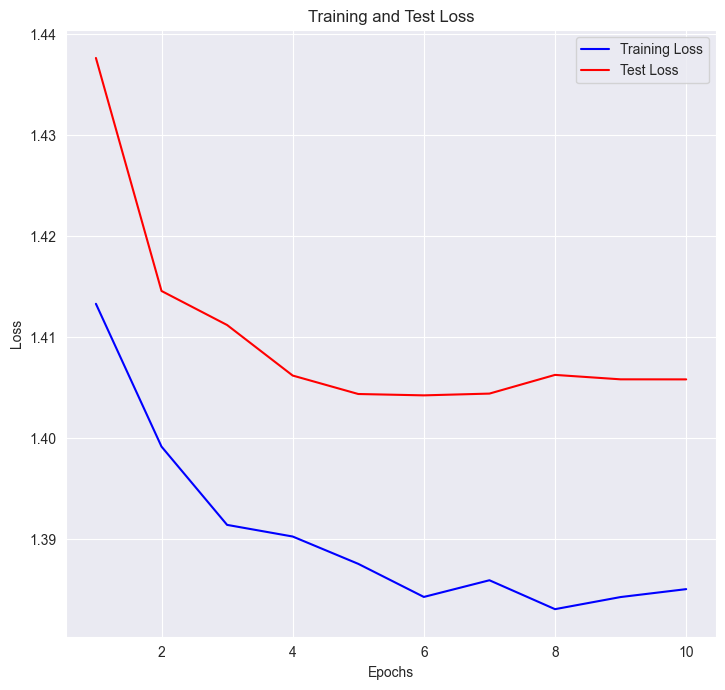


Evaluating Improved RNN model for effectiveness
targets_all [2, 0, 1, 1, 3, 1, 2, 4, 3, 4, 2, 1, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 1, 1, 3, 1, 3, 0, 4, 1, 1, 1, 1, 0, 1, 0, 2, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 4, 4, 0, 4, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 4, 0, 0, 4, 4, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 4, 0, 1, 1, 0, 4, 0, 1, 1, 0, 1, 1, 4, 0, 2, 2, 4, 1, 1, 3, 1, 2, 1, 1, 0, 0, 0, 4, 0, 1, 4, 4, 1, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 2, 3, 1, 4, 1, 4, 1, 1, 0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 4, 4, 0, 3, 0, 1, 1, 0, 1, 2, 1, 0, 4, 4, 2, 1, 1, 4, 0, 3, 1, 0, 4, 4, 1, 0, 1, 0, 1, 1, 0, 4, 4, 1, 3, 1, 1, 2, 2, 1, 0, 0, 1, 4, 3, 0, 4, 4, 4, 1, 1, 0, 1, 1, 1, 4, 1, 0, 4, 1, 3, 1, 4, 4, 1, 0, 1, 1, 0, 0, 3, 0, 0, 0, 3, 3, 1, 4, 0, 1, 2, 1, 1, 4, 1, 1, 1, 4, 2, 1, 3, 1, 0, 0, 0, 1, 1, 4, 4, 4, 4, 0, 1, 0, 1, 4, 2, 1, 0, 0, 4, 2, 4, 0, 3, 2, 3, 4, 1, 4, 1, 0, 1, 0, 1, 2, 1, 0, 2, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 1, 2, 1, 4, 3, 1,

/Users/rmajor/Library/Caches/pypoetry/virtualenvs/neuralnetworks-S6rdj6Tk-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


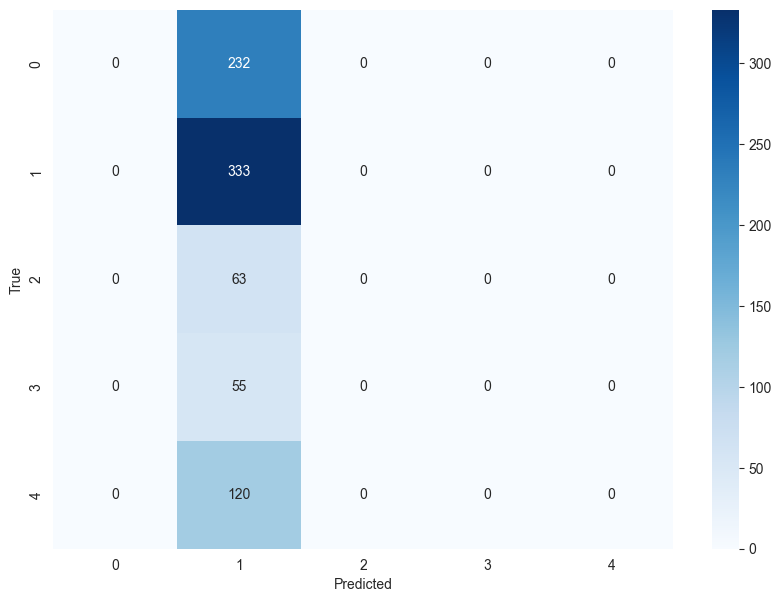


Training RNN model for sideEffects
Epoch 1/10, Training Loss: 1.5129, Training Accuracy: 0.3201, Test Loss: 1.5433, Test Accuracy: 0.3088
Epoch 2/10, Training Loss: 1.4931, Training Accuracy: 0.3180, Test Loss: 1.5280, Test Accuracy: 0.3088
Epoch 3/10, Training Loss: 1.4970, Training Accuracy: 0.3233, Test Loss: 1.5431, Test Accuracy: 0.3088
Epoch 4/10, Training Loss: 1.4923, Training Accuracy: 0.3208, Test Loss: 1.5593, Test Accuracy: 0.3088
Epoch 5/10, Training Loss: 1.4886, Training Accuracy: 0.3177, Test Loss: 1.5494, Test Accuracy: 0.3088
Epoch 6/10, Training Loss: 1.4873, Training Accuracy: 0.3242, Test Loss: 1.5535, Test Accuracy: 0.3088
Epoch 7/10, Training Loss: 1.4867, Training Accuracy: 0.3205, Test Loss: 1.5560, Test Accuracy: 0.3088
Epoch 8/10, Training Loss: 1.4855, Training Accuracy: 0.3230, Test Loss: 1.5515, Test Accuracy: 0.3088
Epoch 9/10, Training Loss: 1.4840, Training Accuracy: 0.3217, Test Loss: 1.5489, Test Accuracy: 0.3088
Epoch 10/10, Training Loss: 1.4835, T

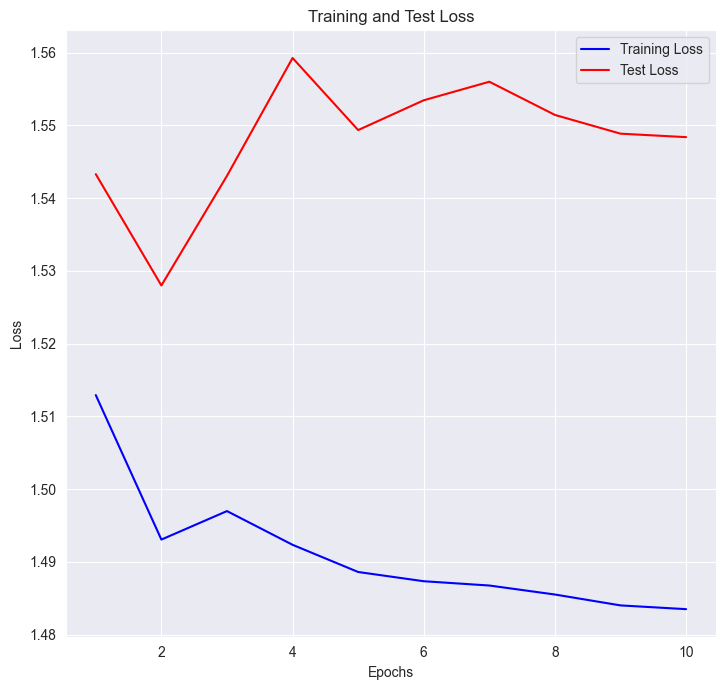


Evaluating Improved RNN model for sideEffects
targets_all [2, 3, 1, 3, 1, 3, 0, 1, 2, 2, 1, 3, 2, 1, 1, 2, 1, 3, 3, 2, 2, 3, 3, 3, 1, 1, 0, 1, 2, 4, 3, 3, 1, 4, 1, 3, 2, 2, 2, 4, 3, 1, 3, 2, 1, 3, 2, 4, 4, 0, 1, 1, 1, 0, 3, 3, 3, 1, 4, 1, 3, 3, 1, 4, 2, 2, 2, 4, 1, 2, 3, 1, 1, 4, 2, 3, 1, 1, 2, 1, 2, 3, 3, 1, 3, 1, 4, 3, 2, 3, 1, 2, 3, 0, 3, 4, 3, 1, 1, 1, 4, 2, 4, 3, 4, 3, 3, 2, 1, 1, 1, 1, 4, 3, 3, 2, 1, 3, 3, 4, 1, 3, 3, 3, 2, 1, 3, 4, 4, 1, 3, 3, 2, 1, 3, 2, 4, 1, 3, 3, 4, 1, 4, 2, 1, 3, 1, 4, 2, 3, 2, 1, 1, 2, 0, 3, 3, 1, 3, 1, 1, 1, 1, 1, 0, 1, 4, 2, 2, 2, 2, 3, 2, 2, 1, 1, 2, 0, 0, 3, 1, 4, 4, 3, 3, 2, 1, 3, 1, 2, 1, 0, 2, 1, 1, 3, 0, 1, 1, 1, 0, 3, 4, 1, 1, 4, 0, 3, 2, 4, 1, 1, 4, 2, 1, 3, 1, 1, 1, 1, 1, 2, 2, 3, 1, 4, 2, 3, 4, 1, 3, 4, 2, 1, 1, 1, 1, 2, 1, 3, 3, 1, 2, 1, 3, 2, 3, 3, 4, 3, 4, 3, 3, 3, 3, 1, 2, 3, 4, 3, 4, 2, 3, 4, 3, 2, 0, 2, 1, 2, 1, 4, 0, 3, 0, 1, 3, 3, 4, 0, 4, 3, 0, 0, 0, 2, 1, 2, 2, 2, 3, 3, 1, 0, 3, 1, 2, 1, 0, 1, 1, 1, 0, 0, 3, 1, 3, 1, 2, 3, 2, 0, 3, 0

/Users/rmajor/Library/Caches/pypoetry/virtualenvs/neuralnetworks-S6rdj6Tk-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


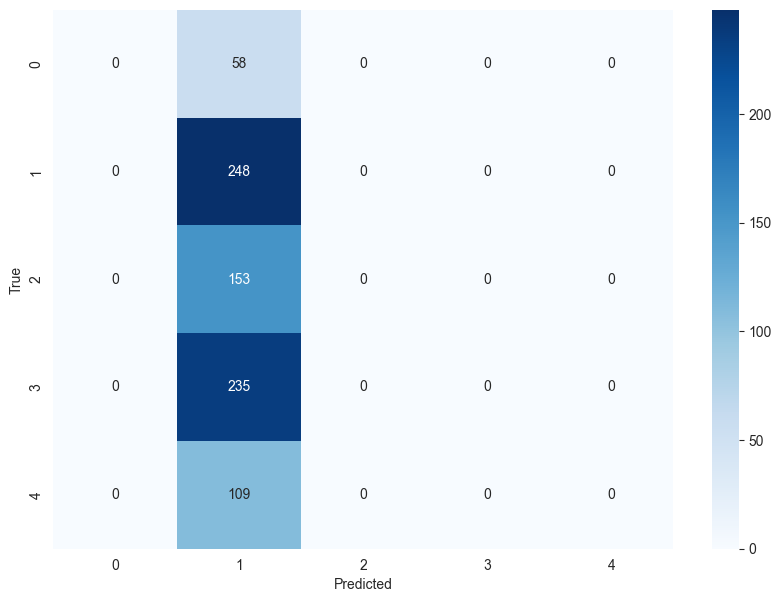

In [65]:
from torch import optim

train_data_loaders = {
    'rating': data_loader_rating_train,
    'effectiveness': data_loader_effectiveness_train,
    'sideEffects': data_loader_side_effects_train
}

test_data_loaders = {
    'rating': data_loader_rating_test,
    'effectiveness': data_loader_effectiveness_test,
    'sideEffects': data_loader_side_effects_test
}

rnns = {
    'rating': RNNClassifier(vocab_size, embedding_dim, hidden_size, output_sizes['rating']),
    'effectiveness': RNNClassifier(vocab_size, embedding_dim, hidden_size, output_sizes['effectiveness']),
    'sideEffects': RNNClassifier(vocab_size, embedding_dim, hidden_size, output_sizes['sideEffects'])
}

if __name__ == '__main__':
    for target, model in rnns.items():
        model.to(device)
        train_loader = train_data_loaders[target]
        test_loader = test_data_loaders[target]
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print(f"\nTraining RNN model for {target}")
        train_losses, test_losses, train_accuracies, test_accuracies = train_model(
            model, optimizer, train_loader, test_loader, nn.CrossEntropyLoss()
        )
        plot_learning_curves(train_losses, test_losses)
        print(f"\nEvaluating Improved RNN model for {target}")
        evaluate_model(model, test_loader, nn.CrossEntropyLoss())

In [40]:
test_loader = test_data_loaders[target]

In [41]:
test_loader

In [ ]:
from torch import optim

GRUs = {
    'rating': GRUClassifier(vocab_size, embedding_dim, hidden_size, output_sizes['rating']),
    'effectiveness': GRUClassifier(vocab_size, embedding_dim, hidden_size, output_sizes['effectiveness']),
    'sideEffects': GRUClassifier(vocab_size, embedding_dim, hidden_size, output_sizes['sideEffects'])
}

if __name__ == '__main__':
    for target, model in rnns.items():
        model.to(device)
        train_loader = train_data_loaders[target]
        test_loader = test_data_loaders[target]
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print(f"\nTraining GRU model for {target}")
        train_losses, test_losses, train_accuracies, test_accuracies = train_model(
            model, optimizer, train_loader, test_loader, nn.CrossEntropyLoss()
        )
        plot_learning_curves(train_losses, test_losses)
        print(f"\nEvaluating GRU model for {target}")
        evaluate_model(model, test_loader, nn.CrossEntropyLoss())

In [ ]:
GRULSTMs = {
    'rating': GRULSTMClassifier(vocab_size, embedding_dim, hidden_size, output_sizes['rating']),
    'effectiveness': GRULSTMClassifier(vocab_size, embedding_dim, hidden_size, output_sizes['effectiveness']),
    'sideEffects': GRULSTMClassifier(vocab_size, embedding_dim, hidden_size, output_sizes['sideEffects'])
}

if __name__ == '__main__':
    for target, model in rnns.items():
        model.to(device)
        train_loader = train_data_loaders[target]
        test_loader = test_data_loaders[target]
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print(f"\nTraining GRULSTM model for {target}")
        train_losses, test_losses, train_accuracies, test_accuracies = train_model(
            model, optimizer, train_loader, test_loader, nn.CrossEntropyLoss()
        )
        plot_learning_curves(train_losses, test_losses)
        print(f"\nEvaluating Improved GRULSTM  model for {target}")
        evaluate_model(model, test_loader, nn.CrossEntropyLoss())